In [77]:
#Import Statement
from datetime import date
import holidays
import pandas as pd
from math import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
import io
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from statsmodels.tsa.api import VAR

In [2]:
uploaded = files.upload()

Saving electricity_demand.csv to electricity_demand.csv


In [44]:
#Fetch the dataset
dataset = pd.read_csv(io.BytesIO(uploaded['electricity_demand.csv']))
dataset.head()

,date,demand,RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
0,1/1/2015,99635.030,25.633696,13.3,5.186521,0.000000,0.0,N,Y
1,1/2/2015,129606.010,33.138988,15.4,6.228965,0.880597,0.0,N,N
2,1/3/2015,142300.540,34.564855,20.0,6.180615,1.011321,0.0,N,N
3,1/4/2015,104330.715,25.005560,16.3,4.626013,1.051587,4.2,N,N
4,1/5/2015,118132.200,26.724176,15.0,4.690416,0.820847,0.0,N,N


In [45]:
dataset['date'] = pd.to_datetime(dataset['date'], infer_datetime_format=True)

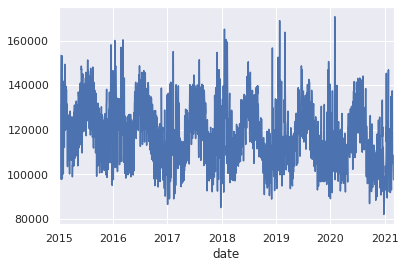

In [46]:
dataset.set_index('date')['demand'].plot()

In [47]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2251 entries, 0 to 2250
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             2251 non-null   datetime64[ns]
 1   demand           2251 non-null   float64       
 2   RRP              2251 non-null   float64       
 3   min_temperature  2251 non-null   float64       
 4   max_temperature  2251 non-null   float64       
 5   solar_exposure   2251 non-null   float64       
 6   rainfall         2251 non-null   float64       
 7   school_day       2251 non-null   object        
 8   holiday          2251 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 158.4+ KB


In [48]:
dataset.count()

date               2251
demand             2251
RRP                2251
min_temperature    2251
max_temperature    2251
solar_exposure     2251
rainfall           2251
school_day         2251
holiday            2251
dtype: int64

In [49]:
dataset.set_index('date', inplace=True)

In [50]:
dataset['school_day'] = dataset['school_day'].replace(to_replace ="N", value = 0)
dataset['school_day'] = dataset['school_day'].replace(to_replace ="Y", value = 1)
dataset['holiday'] = dataset['holiday'].replace(to_replace ="N", value = 0)
dataset['holiday'] = dataset['holiday'].replace(to_replace ="Y", value = 1)

In [51]:
training_set = dataset.iloc[:2191]
testing_set = dataset.iloc[2192:]

In [52]:
print(training_set.tail())
print(testing_set.head())

               demand        RRP  ...  school_day  holiday
date                              ...                     
2020-12-26  88980.895  31.239583  ...           0        0
2020-12-27  96137.560   6.380417  ...           0        0
2020-12-28  85792.090   8.254583  ...           0        1
2020-12-29  90537.375  23.902917  ...           0        0
2020-12-30  93732.335  29.288958  ...           0        0

[5 rows x 8 columns]
                demand        RRP  ...  school_day  holiday
date                               ...                     
2021-01-01   92926.685  18.296383  ...           0        1
2021-01-02   98995.065  21.890208  ...           0        0
2021-01-03   94371.480  19.487708  ...           0        0
2021-01-04   99640.535   4.791042  ...           0        0
2021-01-05  103840.455   7.464583  ...           0        0

[5 rows x 8 columns]


In [53]:
testing_set.shape

(59, 8)

In [64]:
forecasting_model = VAR(training_set)
results_aic = []
for p in range(1,30):
  results = forecasting_model.fit(p)
  results_aic.append(results.aic)

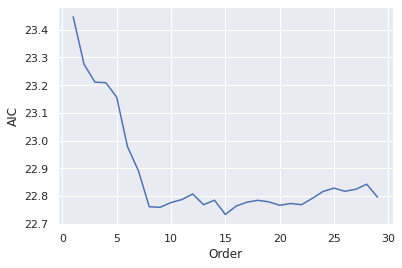

In [65]:
sns.set()
plt.plot(list(np.arange(1,30,1)), results_aic)
plt.xlabel("Order")
plt.ylabel("AIC")
plt.show()

In [66]:
results = forecasting_model.fit(15)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 05, May, 2021
Time:                     10:10:50
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    25.2627
Nobs:                     2176.00    HQIC:                   23.6583
Log likelihood:          -48467.0    FPE:                7.47260e+09
AIC:                      22.7336    Det(Omega_mle):     4.84680e+09
--------------------------------------------------------------------
Results for equation demand
                         coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------
const                   39744.058111      6199.673925            6.411           0.000
L1.demand                   0.823539         0.024034           34.265           0.000
L1.RRP                      3.70341

In [73]:
print(results.k_ar)
laaged_values = training_set.values[-results.k_ar:]
forecast = pd.DataFrame(results.forecast(y= laaged_values, steps=59), index = testing_set.index)
forecast

15


,0,1,2,3,4,5,6,7
date,,,,,,,,
2021-01-01,98963.695263,-13.767266,12.832427,4.884844,0.953007,1.280129,0.093304,0.154526
2021-01-02,98089.291266,83.619691,12.815915,4.540559,1.400540,0.339981,0.162511,-0.029336
2021-01-03,92696.304948,158.525314,12.149436,4.854530,0.942241,1.032070,0.044116,0.047715
2021-01-04,92868.629292,80.606607,13.577324,4.856301,1.067248,5.689020,0.038793,0.009797
2021-01-05,105995.983103,55.668282,13.561114,4.822440,1.014104,-0.948197,0.106658,0.024459
2021-01-06,107469.383007,36.042340,13.305462,4.967136,1.618576,1.361348,0.185061,0.024790
2021-01-07,111077.099846,45.705137,14.819407,4.929254,1.343474,1.480124,0.109608,-0.058362
2021-01-08,106613.888353,49.526038,13.815456,4.841144,0.629754,2.169921,0.186796,0.049915
2021-01-09,106304.889510,27.479025,13.571103,4.898035,1.794833,1.222183,0.207975,0.067520


In [69]:
output = pd.DataFrame()
output['demand'] = testing_set['demand']
output['forecasted_demand'] = forecast[0]

In [70]:
output

,demand,forecasted_demand
date,,
2021-01-01,92926.685,98963.695263
2021-01-02,98995.065,98089.291266
2021-01-03,94371.480,92696.304948
2021-01-04,99640.535,92868.629292
2021-01-05,103840.455,105995.983103
2021-01-06,100748.620,107469.383007
2021-01-07,100672.950,111077.099846
2021-01-08,103763.200,106613.888353
2021-01-09,106315.210,106304.889510


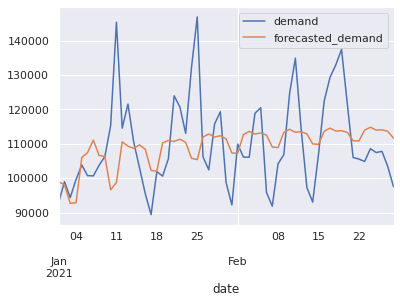

In [71]:
output.plot()

In [79]:
mean_absolute_error(output['demand'],output['forecasted_demand'])

10111.69206205011

In [80]:
sqrt(mean_squared_error(output['demand'],output['forecasted_demand']))

13340.992639503422